In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import xgboost as xgb
import logging
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_fscore_support)
from scipy.stats import uniform, randint


In [40]:
train_df = pd.read_csv("train.csv")
print(train_df.dtypes)


print("No Duplicate Rows")

train_df.drop(columns=['ID'], inplace=True)

train_df['STAY_DRG_CD'] = train_df['STAY_DRG_CD'].fillna(train_df['stay_drg_cd'].astype(float, errors='ignore'))


diagnosis_cols = [col for col in train_df.columns if col.startswith('DGNSCD')]
train_df[diagnosis_cols] = train_df[diagnosis_cols].fillna('NO_DIAG')

procedure_cols = [col for col in train_df.columns if col.startswith('PRCDRCD')]
train_df[procedure_cols] = train_df[procedure_cols].fillna('NO_PROC')

train_df = train_df.drop(columns=['stay_drg_cd'])


train_df['STAY_DRG_CD'] = pd.to_numeric(train_df['STAY_DRG_CD'], errors='coerce')

train_df['STAY_FROM_DT'] = pd.to_datetime(train_df['STAY_FROM_DT'], errors='coerce')
train_df['STAY_THRU_DT'] = pd.to_datetime(train_df['STAY_THRU_DT'], errors='coerce')




diag_cols = [col for col in train_df.columns if col.startswith('DGNSCD') or col == 'AD_DGNS']
proc_cols = [col for col in train_df.columns if col.startswith('PRCDRCD')]

train_df[diag_cols + proc_cols] = train_df[diag_cols + proc_cols].astype('category')

train_df = train_df[~train_df['STAY_DRG_CD'].isin([None, '-'])]



train_df['STAY_DRG_CD'] = train_df['STAY_DRG_CD'].replace({
    '-': None,       
    'NA': None,     
    'missing': None, 
    '': None         
})

train_df['Readmitted_30'] = train_df['Readmitted_30'].astype('category')
train_df['STUS_CD'] = train_df['STUS_CD'].astype('category')
train_df['TYPE_ADM'] = train_df['TYPE_ADM'].astype('category')
train_df['SRC_ADMS'] = train_df['SRC_ADMS'].astype('category')
train_df['STAY_DRG_CD'] = train_df['STAY_DRG_CD'].astype('category')

train_df['STAY_DRG_CD'].fillna(np.nan, inplace=True)

print(train_df.dtypes)
print(train_df.isnull().sum())


ID                 int64
STAY_DRG_CD      float64
STAY_FROM_DT      object
STAY_THRU_DT      object
STUS_CD            int64
TYPE_ADM           int64
SRC_ADMS           int64
AD_DGNS           object
DGNSCD01          object
PRCDRCD01         object
DGNSCD02          object
PRCDRCD02         object
DGNSCD03          object
PRCDRCD03         object
DGNSCD04          object
PRCDRCD04         object
DGNSCD05          object
PRCDRCD05         object
DGNSCD06          object
PRCDRCD06         object
DGNSCD07          object
PRCDRCD07         object
DGNSCD08          object
PRCDRCD08         object
DGNSCD09          object
PRCDRCD09         object
DGNSCD10          object
PRCDRCD10         object
DGNSCD11          object
PRCDRCD11         object
DGNSCD12          object
PRCDRCD12         object
DGNSCD13          object
PRCDRCD13         object
DGNSCD14          object
PRCDRCD14         object
DGNSCD15          object
PRCDRCD15         object
DGNSCD16          object
PRCDRCD16         object


C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_17168\2541871548.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['STAY_DRG_CD'].fillna(np.nan, inplace=True)


2025-04-25 13:07:24,239 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_17168\3699562808.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Readmitted_30', data=train_df, palette='Set2')
2025-04-25 13:07:24,286 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



🔍 Class Distribution:
Readmitted_30
0    103598
1     26698
Name: count, dtype: int64

📊 Class Distribution (Percentages):
Readmitted_30
0    79.51
1    20.49
Name: proportion, dtype: float64


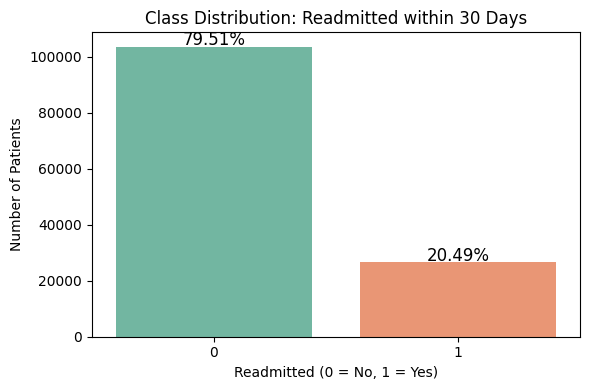


🔍 Class Distribution:
Readmitted_30
0    103598
1    103598
Name: count, dtype: int64

📊 Class Distribution (Percentages):
Readmitted_30
0    50.0
1    50.0
Name: proportion, dtype: float64


In [30]:

class_counts = train_df['Readmitted_30'].value_counts()
class_percentages = train_df['Readmitted_30'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(class_counts)

print("\nClass Distribution (Percentages):")
print(class_percentages.round(2))

plt.figure(figsize=(6, 4))
sns.countplot(x='Readmitted_30', data=train_df, palette='Set2')

for i, (count, pct) in enumerate(zip(class_counts, class_percentages)):
    plt.text(i, count + 500, f'{pct:.2f}%', ha='center', fontsize=12)

plt.title('Class Distribution: Readmitted within 30 Days')
plt.xlabel('Readmitted (0 = No, 1 = Yes)')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

from sklearn.utils import resample

df_majority = train_df[train_df['Readmitted_30'] == 0]
df_minority = train_df[train_df['Readmitted_30'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True, 
    n_samples = int(len(df_majority)),
    random_state=42
)

train_df_balanced = pd.concat([df_majority, df_minority_upsampled])
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

class_counts = train_df_balanced['Readmitted_30'].value_counts()
class_percentages = train_df_balanced['Readmitted_30'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(class_counts)

print("\nClass Distribution (Percentages):")
print(class_percentages.round(2))



2025-04-25 12:13:57,961 - INFO - Splitting the dataset into train and test sets.
2025-04-25 12:13:58,025 - INFO - Defining XGBoost model.
2025-04-25 12:13:58,029 - INFO - Starting hyperparameter tuning with RandomizedSearchCV.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:22:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025-04-25 12:22:44,932 - INFO - ✅ Best Parameters found by RandomizedSearchCV:
2025-04-25 12:22:44,933 - INFO - {'colsample_bytree': 0.6028265220878869, 'gamma': 0.009224970016566303, 'learning_rate': 0.16743239807751675, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 1999, 'subsample': 0.8056937753654446}
2025-04-25 12:22:44,934 - INFO - 🏆 Best AUC Score from Cross-Validation:
2025-04-25 12:22:44,934 - INFO - 0.9635998411905569
2025-04-25 12:22:44,935 - INFO - Training final model on the entire training set with best hyperparameters.
C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:22:45] WARNING: C:\actions-runner\_work\xgboost\xg

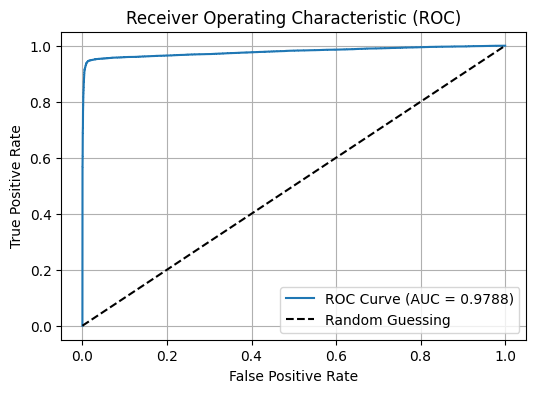

2025-04-25 12:23:01,046 - INFO - Plotting feature importance.
C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_17168\260179693.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')


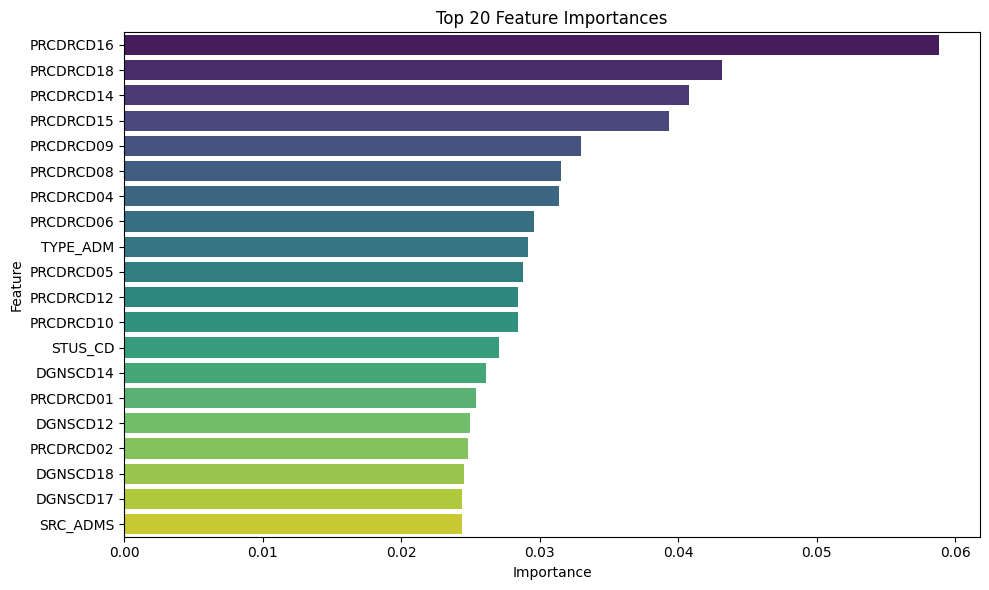

In [24]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

selected_columns = [
    'STAY_DRG_CD', 'STUS_CD', 'TYPE_ADM', 'SRC_ADMS', 'AD_DGNS',
    'DGNSCD01', 'DGNSCD02', 'DGNSCD03', 'DGNSCD04', 'DGNSCD05',
    'DGNSCD06', 'DGNSCD07', 'DGNSCD08', 'DGNSCD09', 'DGNSCD10',
    'DGNSCD11', 'DGNSCD12', 'DGNSCD13', 'DGNSCD14', 'DGNSCD15',
    'DGNSCD16', 'DGNSCD17', 'DGNSCD18', 'PRCDRCD01', 'PRCDRCD02',
    'PRCDRCD03', 'PRCDRCD04', 'PRCDRCD05', 'PRCDRCD06',
    'PRCDRCD08', 'PRCDRCD09', 'PRCDRCD10', 'PRCDRCD12',
    'PRCDRCD14', 'PRCDRCD15', 'PRCDRCD16', 'PRCDRCD17', 'PRCDRCD18'
]

X = train_df_balanced[selected_columns].copy()
y = train_df_balanced['Readmitted_30'].astype(int)

label_encoder = LabelEncoder()
for col in selected_columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))

logging.info("Splitting the dataset into train and test sets.")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

logging.info("Defining XGBoost model.")
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': randint(100, 2000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.4),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

logging.info("Starting hyperparameter tuning with RandomizedSearchCV.")
random_search.fit(X_train, y_train)

logging.info("Best Parameters found by RandomizedSearchCV:")
logging.info(random_search.best_params_)

logging.info(random_search.best_score_)

logging.info("Training final model on the entire training set with best hyperparameters.")
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

logging.info("Evaluating final model on test set.")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

logging.info("\nFinal Test Set Performance:")
logging.info(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
logging.info(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
logging.info("\nClassification Report:\n" + classification_report(y_test, y_pred))
logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))

logging.info("Plotting ROC curve.")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

logging.info("Plotting feature importance.")
importances = best_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()
